In [45]:

import pickle as pk
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import scipy as sc

import os


os.getcwd()

'/home/ubuntu/sandler_gpatlas_data/alphasimr'

In [46]:
#pickled captum feature ablation output
in_data = pk.load(open('gpatlas_out/g_p_attr_individual_pheno.pk','rb'))

#read in input into model to get labels of input features
#linear model reference
linear_mod = pd.read_csv('sim_2trait_jan02_eff2.txt', sep=' ')


In [47]:
n_loci = len(linear_mod)
n_pheno = 2


In [48]:
#batch = in_data[0] #select one batch
def largest_abs_value(group):
    return group.loc[group.abs().idxmax()]



batch = []
master_df = pd.DataFrame()
for i in range(len(in_data)):
    batch = in_data[i] #select data from one batch
    batch_pheno_catch = np.empty((0, n_loci))

    for pheno in range(n_pheno):
        #print(pheno)
        batch_pheno = batch[pheno::n_pheno] #select one pheno
        batch_catch = []

        for sample in range(len(batch_pheno)):
            batch_pheno_sample = batch_pheno[sample] #subset to sample (shape = 1 sample * nloci * nalleles)
            #calculate overall allelic effect (mean) at site across 3 alleles (shape = nsamples * nloci)
            batch_pheno_sample_allele = [np.mean((batch_pheno_sample[i:i+2])) for i in range(0, len(batch_pheno_sample), 2)]
            batch_catch += batch_pheno_sample_allele

        #reshape so each sample is one sub-array n-loci long (shape = nsamples * (nloci))
        batch_catch_reshaped = np.array(batch_catch).reshape(-1, n_loci)
        #calculate mean for each locus across all samples in batch (shape = nloci)
        column_means = np.mean(batch_catch_reshaped, axis=0)
        batch_pheno_catch =np.vstack((batch_pheno_catch, column_means.T))

        dff = pd.DataFrame(batch_pheno_catch).T
        dff['batch'] = i

    master_df = pd.concat([master_df, dff], axis=0, ignore_index=True)
    # Assign a row index within each batch
    master_df['row_index'] = master_df.groupby('batch').cumcount()
    # Reshape the data for aggregation
    reshaped = master_df.melt(id_vars=['batch', 'row_index'], var_name='column', value_name='value')
    # Calculate the mean for each (row_index, column) pair across batches
    result = reshaped.groupby(['row_index', 'column'])['value'].mean().unstack()

result.to_pickle('feature_ablation_summary_per_pheno.pk')

#column_means_df = pd.DataFrame(column_means)


In [49]:
result = pk.load(open('feature_ablation_summary_per_pheno.pk','rb'))
print(result)

column            0         1
row_index                    
0         -0.012975 -0.006758
1          0.002938  0.000282
2          0.000418 -0.001322
3          0.007737 -0.003208
4         -0.002646  0.003987
...             ...       ...
4202      -0.007402  0.001905
4203       0.007933 -0.003639
4204       0.000462  0.003053
4205      -0.004023  0.001618
4206       0.003671  0.004798

[4207 rows x 2 columns]


In [50]:
#precomputed feature ablation summaries per phenotype
result = pk.load(open('feature_ablation_summary_per_pheno.pk','rb'))
print(result)
#print(result.head())


data_full = pd.concat([result, linear_mod], axis=1)
print(data_full.head())


column            0         1
row_index                    
0         -0.012975 -0.006758
1          0.002938  0.000282
2          0.000418 -0.001322
3          0.007737 -0.003208
4         -0.002646  0.003987
...             ...       ...
4202      -0.007402  0.001905
4203       0.007933 -0.003639
4204       0.000462  0.003053
4205      -0.004023  0.001618
4206       0.003671  0.004798

[4207 rows x 2 columns]
          0         1  locus   add_eff  epi_loc   epi_eff       sfs
0 -0.012975 -0.006758      1  0.000000     41.0 -0.166936  0.313667
1  0.002938  0.000282      2  0.000000     42.0  0.330392  0.003000
2  0.000418 -0.001322      3  0.000000    624.0  0.154208  0.041667
3  0.007737 -0.003208      4  0.000000    903.0  0.002112  0.456333
4 -0.002646  0.003987      5 -0.007634    379.0  0.178511  0.008667


In [51]:
#for i in range(n_pheno):
    #data_full[str(i)+"rank"] = data_full[i].abs().rank(ascending=True)


Text(0.5, 1.0, 'trait1')

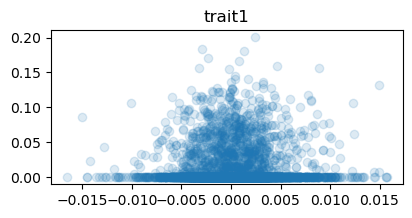

In [52]:

plt.figure(figsize=(10, n_pheno))


plt.subplot(1, n_pheno, 1)  # row 1, column 2, count 1
plt.scatter(data_full[0], abs(data_full['add_eff']),alpha=0.15)
plt.title('trait1')

#plt.subplot(1, n_pheno, 2)
#plt.scatter(data_full[1], data_full['add_eff'],alpha=0.15)
#plt.title('trait2')


Text(0.5, 1.0, 'trait1')

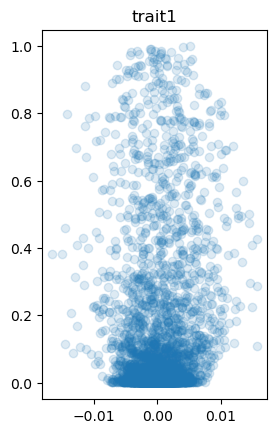

In [53]:
plt.subplot(1, n_pheno, 1)  # row 1, column 2, count 1
plt.scatter(data_full[0], abs(data_full['sfs']),alpha=0.15)
plt.title('trait1')

Text(0.5, 0, 'real')

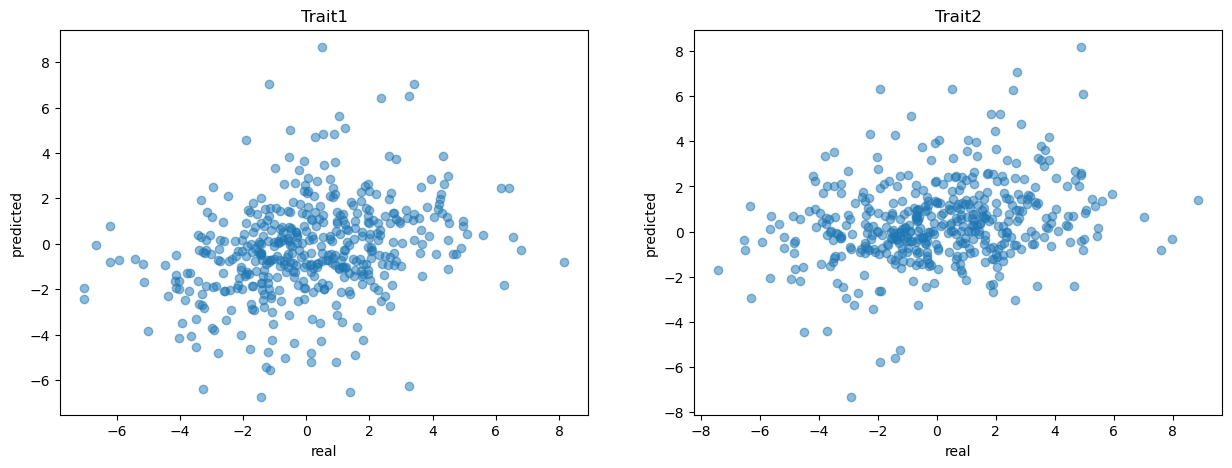

In [54]:


#phenotypes, phenotype encodings and pheno latent from G-P model
#can use to visualuze latent space
in_data3 = pk.load(open("gpatlas_out/phens_phen_encodings_dng_gp.pk",'rb'))


raw_pheno = pd.DataFrame(in_data3[0].T, columns=['Trait1', 'Trait2'])
pred_pheno = pd.DataFrame(in_data3[1].T, columns=['Trait1', 'Trait2'])



plt.figure(figsize=(15, 5))


plt.subplot(1, 2, 1)  # row 1, column 2, count 1
plt.scatter(raw_pheno['Trait1'], pred_pheno['Trait1'],alpha=0.5)
plt.title('Trait1')
plt.ylabel("predicted")
plt.xlabel("real")


plt.subplot(1, 2, 2)  # row 1, column 2, count 1
plt.scatter(raw_pheno['Trait2'], pred_pheno['Trait2'],alpha=0.5)
plt.title('Trait2')
plt.ylabel("predicted")
plt.xlabel("real")


In [55]:

r_squared = r2_score(raw_pheno["Trait1"], pred_pheno["Trait1"])
print(r_squared, "Trait1")

r_squared = r2_score(raw_pheno["Trait2"], pred_pheno["Trait2"])
print(r_squared, "Trait2")


from scipy.stats import pearsonr
r, _ = pearsonr(raw_pheno["Trait1"], pred_pheno["Trait1"])
r_squared = r**2
print(r, "Trait1")


r, _ = pearsonr(raw_pheno["Trait2"], pred_pheno["Trait2"])
r_squared = r
print(r, "Trait2")


-0.28505563735961914 Trait1
-0.11762630939483643 Trait2
0.2881079531221644 Trait1
0.26347168059402293 Trait2
